In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from functools import reduce
from brokenaxes import brokenaxes

# Load isoform
SL1=pd.read_csv(r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\SL1\RSEM.isoforms.results', sep='\t')
SL2=pd.read_csv(r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\SL2\RSEM.isoforms.results', sep='\t')
SL3=pd.read_csv(r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\SL3\RSEM.isoforms.results', sep='\t')
SL4=pd.read_csv(r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\SL4\RSEM.isoforms.results', sep='\t')
libs=[SL1,SL2,SL3,SL4]
# Rename columns with isoform FPKM levels name sufix
for i, df in enumerate(libs):
    df.columns = [f"{col}_SL{i+1}" if col != 'transcript_id' else col for col in df.columns]
filtered_dfs = [df[['transcript_id'] + [col for col in df.columns if 'FPKM' in col]] for df in libs]
df_merged = reduce(lambda left, right: pd.merge(left, right, on='transcript_id', how='outer'), filtered_dfs)

# Load genes
SL1_g=pd.read_csv(r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\SL1\RSEM.genes.results', sep='\t')
SL2_g=pd.read_csv(r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\SL2\RSEM.genes.results', sep='\t')
SL3_g=pd.read_csv(r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\SL3\RSEM.genes.results', sep='\t')
SL4_g=pd.read_csv(r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\SL4\RSEM.genes.results', sep='\t')
libs_g=[SL1_g,SL2_g,SL3_g,SL4_g]
# Rename columns with gene FPKM levels name sufix
for i, df_g in enumerate(libs_g):
    df_g.columns = [f"{col}_g_SL{i+1}" if col != 'gene_id' else col for col in df_g.columns]
filtered_dfs_g = [df_g[['gene_id'] + [col for col in df_g.columns if 'FPKM' in col]] for df_g in libs_g]
df_merged_g = reduce(lambda left, right: pd.merge(left, right, on='gene_id', how='outer'), filtered_dfs_g)

# Load taxonomy
read_tax = pd.read_csv(r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\Megan\transcript_pep_taxpath.tsv',header=None, sep='\t')
read_tax[[2]] = read_tax[0].str.split('.', expand=True).drop(columns=1)
split_values = read_tax[1].str.split(';')
new_values = split_values.apply(lambda x: ';'.join(x[4:5]) if len(x) >= 6 else ';'.join(x[-2:]))
read_tax[1] = new_values
bac = pd.read_csv(r'd:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\Megan\Bacterial_reads\bac_read.txt',header=None)#[0].str.split('_i',expand=True)
#bac = bac[0].drop_duplicates()

# Load annotation
annotate = pd.read_csv(r'd:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\trinity_out_dir.Trinity_trinotate_annotation_report.tsv', sep='\t')
# Load localisation
deeploc=pd.read_csv(r'd:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\localisation\all\deeploc2_out.csv')
asafind=pd.read_csv(r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\localisation\all\asafind.tab', sep='\t')
targetp=pd.read_csv(r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\localisation\all\trinity_out_dir.Trinity.fasta.transdecoder_summary.targetp', sep='\t',skiprows=1)
localisation = targetp.iloc[:, [0, 1]].merge(asafind.iloc[:, [0, 6]], left_on=targetp.columns[0], right_on=asafind.columns[0], how='left').merge(deeploc.iloc[:, [0, 1]], left_on=targetp.columns[0], right_on=deeploc.columns[0], how='left')
localisation = localisation.iloc[:,[0,1,3,5]]
localisation = localisation.rename(columns={'# ID': 'Protien ID', 'Prediction': 'TargetP2', 'ASAFind 2.0_beta25 Prediction, score threshold = 0.3100298026055153, with FWYL check': 'ASAFind2','Localizations': 'DeepLoc2'})
localisation.loc[localisation['ASAFind2'] == 'SignalP-4.1: N', 'ASAFind2'] = 'None'

# Load avp
avp = pd.read_csv(r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\Megan\Bacterial_reads\avp\classification_tree_results.txt', header=None, sep='\t')

# Load Nisaea sp. blastn hits
nis_blastn = pd.read_csv(r'D:\Uni\Dino\Projects\Sino\sym2\bin\scaffolds.fasta_dastool_output_DASTool_bins\contig2bin38\wo_16S\PROKKA_03012024\PROKKA_03012024_v_transcriptome.blastn', header=None,sep='\t')

# Load Transcript lengths
length = pd.read_csv(r'd:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\trinity_out_dir.Trinity.txt', header=None, sep=' ', usecols=[0,1])
length[1] = length[1].str.replace('len=','')
length = length.rename(columns={0:'transcript_id',1:'transcript_length'})

In [ ]:
# Annotation of all reads
filtered_annotate = (pd.merge(df_merged,annotate,left_on='transcript_id',right_on='transcript_id'))
filtered_annotate = (pd.merge(filtered_annotate,length,left_on='transcript_id',right_on='transcript_id'))
# Add taxa annotation
filtered_annotate = (pd.merge(filtered_annotate,read_tax,left_on='prot_id',right_on=0, how='outer'))
filtered_annotate = ((pd.merge(filtered_annotate,avp,left_on='prot_id',right_on=2, how='outer'))
    .rename(columns={'0_y':'AvP_tax','1_x':'Megan_tax'})
    .drop(columns=['0_x','2_x','1_y','2_y']))

# Calculate longest prot to use for representative in table
def calculate_prot(cell):
    if cell == '.':
        return None
    cell = cell.replace('[+]', '')
    cell = cell.replace('[-]', '')
    numbers = cell.split('-')
    return int(numbers[1]) - int(numbers[0])
filtered_annotate['prot_len'] = filtered_annotate['prot_coords'].apply(calculate_prot)

# Add taxonomic information
all_tax = (pd.merge(filtered_annotate,localisation,left_on='prot_id',right_on='Protien ID'))
all_tax = (pd.merge(all_tax,avp,how='left',left_on='prot_id',right_on=2))

# Filtering out nisaea hits that are lower than 100bp and >=98 from all_tax
nis_blastn = nis_blastn[(nis_blastn[3] >= 100) & (nis_blastn[2] >= 98)]
all_tax = all_tax[~all_tax.transcript_id.isin(nis_blastn[1])]

# Add gene expression levels
all_tax_gene = pd.merge(all_tax,df_merged_g,left_on='#gene_id',right_on='gene_id')
all_tax_gene['gene_express'] = (all_tax_gene[['FPKM_g_SL1', 'FPKM_g_SL2', 'FPKM_g_SL3', 'FPKM_g_SL4']] > 1).sum(axis=1)
all_tax_gene = all_tax_gene.drop(columns=[0,1,2,'gene_id'])
all_tax_gene=all_tax_gene.query("gene_express != 0")
(all_tax_gene[['prot_id', 'gene_express', 'Megan_tax','AvP_tax','TargetP2', 'ASAFind2', 'DeepLoc2', 'transcript_length','prot_coords', 'sprot_Top_BLASTX_hit', 'sprot_Top_BLASTP_hit', 'Pfam', 'SignalP', 'TmHMM', 'eggnog', 'Kegg', 'gene_ontology_BLASTX', 'gene_ontology_BLASTP', 'gene_ontology_Pfam', 'FPKM_g_SL1', 'FPKM_g_SL2', 'FPKM_g_SL3', 'FPKM_g_SL4',]]
.to_csv(r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\Megan\20250703_prot_all_tax.csv', index=False))

In [4]:
def comb_go(df, o=5,GO='gene_ontology_BLASTX',title='GO annotation'):
    cc_lis = df[GO].str.findall(r'(?<=cellular_component\^)(.*?)(?=\`|\n)').dropna()
    mf_lis = df[GO].str.findall(r'(?<=molecular_function\^)(.*?)(?=\`|\n)').dropna()
    bp_lis = df[GO].str.findall(r'(?<=biological_process\^)(.*?)(?=\`|\n)').dropna()
    # create a list of dictionaries
    dict_list = [cc_lis, mf_lis, bp_lis]
    # count the number of occurrences of each key in each list
    key_counts_list = []

    for dic_no, d in enumerate(dict_list):
        key_counts = {}
        other_count = {}
        for i in d:
            if not i:  # Skip the iteration if i is empty
                continue
            for key in i:
                key_counts[key] = key_counts.get(key, 0) + 1
        sorted_key_counts = sorted(key_counts.items(), key=lambda item: item[1], reverse=True)
        key_counts = {k: v for k, v in sorted_key_counts if v >= o}
        other_count = {k: v for k, v in sorted_key_counts if v < o}
        key_counts[f"other_{dic_no}"] = sum(other_count.values())
        key_counts_list.append(key_counts)
        #print(key_counts)

    # create a figure for combined plot
    fig, ax = plt.subplots(figsize=(8, 12))
    colors = ['magenta', 'blue', 'green']
    # plot a bar chart for each dictionary
    for i, key_counts in enumerate(key_counts_list):
        labels = list(key_counts.keys())
        values = list(key_counts.values())
        ax.barh(labels, values, color=colors[i], label=['Cellular Component', 
                                                        'Molecular Function', 
                                                        'Biological Process'][i],zorder=2)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(visible=True,which='major',axis='x',zorder=0)
    ax.legend(loc=0, bbox_to_anchor=(1,0.15))
    ax.set_xlabel('Number of transcripts')
    ax.invert_yaxis()
    ax.tick_params(axis='y', labelsize=8)
    ax.margins(y=0.01)

Bacteria only
---


1.0    280
4.0    166
3.0    147
2.0    124
Name: gene_express, dtype: int64


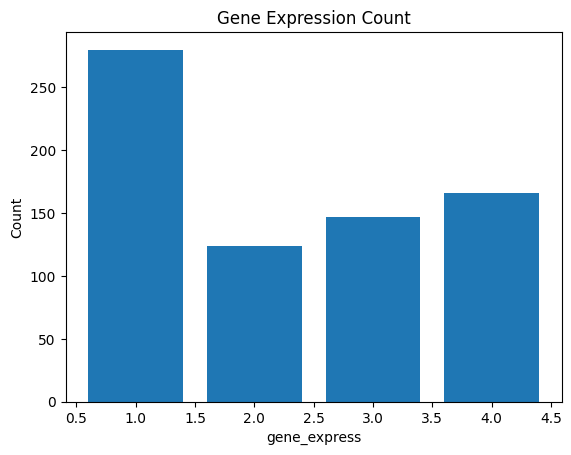

In lib 4
 Bacteria;                              74
 Proteobacteria;                        23
 Alphaproteobacteria                    17
 Actinobacteria                         10
 Gammaproteobacteria                    10
 Bacteroidetes/Chlorobi group            8
 Cyanobacteria/Melainabacteria group     5
 Betaproteobacteria                      3
 Chloroflexi                             3
 Firmicutes                              3
 Terrabacteria group;                    2
 Verrucomicrobia                         2
 PVC group;                              2
 delta/epsilon subdivisions              2
 Acidobacteria;                          1
 Lentisphaerae                           1
Name: Megan_tax, dtype: int64
In lib 3
 Bacteria;                              74
 Proteobacteria;                        20
 Gammaproteobacteria                    14
 Alphaproteobacteria                    12
 Cyanobacteria/Melainabacteria group     6
 Chloroflexi                             4
 Bacte

In [5]:
bac_gene = (pd.merge(all_tax_gene,bac,how='right',left_on='prot_id',right_on=0)).dropna()
bac_gene = bac_gene.drop(columns=[0])
# Now looking at gene level, remove duplicates transcripts, drop duplicates, keep longest protien
bac_gene = bac_gene[bac_gene['gene_express'] != 0]
bac_gene = bac_gene.sort_values(['#gene_id','prot_len','transcript_length'],ascending=[True, False,False]).drop_duplicates(subset=['#gene_id'], keep='first')
all_counts=bac_gene['gene_express'].value_counts()
print(all_counts)
bac_gene.to_csv(r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\Megan\gene_bac_only.csv')

# Plot 
plt.bar(bac_gene['gene_express'].value_counts().index, bac_gene['gene_express'].value_counts().values)
plt.xlabel('gene_express')
plt.ylabel('Count')
plt.title('Gene Expression Count')
#plt.savefig(f"Bac_express_count.svg", format="svg")
plt.show()
for i in [4,3,2,1]:
    print('In lib', i)
    print(bac_gene[bac_gene.gene_express == i]['Megan_tax'].value_counts())

Taxa after removing ambigious taxa, annotation of only BACTERIA

Counts for known taxa
1.0    214
4.0     92
3.0     73
2.0     68
Name: gene_express, dtype: int64


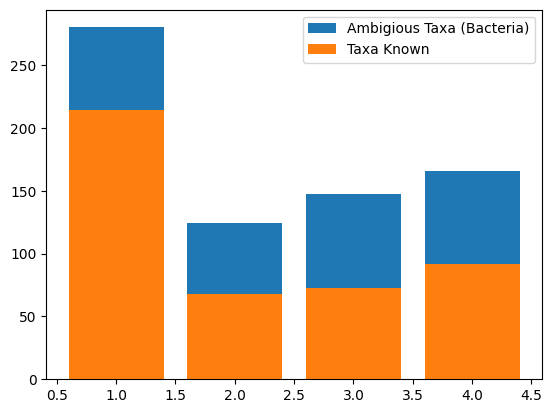

In [6]:
bac_gene = bac_gene[~bac_gene.Megan_tax.str.contains("Bacteria;")]
taxa_known_counts=bac_gene['gene_express'].value_counts()
print('Counts for known taxa')
print(taxa_known_counts)

plt.bar(all_counts.index, all_counts.values,label='Ambigious Taxa (Bacteria)')
plt.bar(taxa_known_counts.index, taxa_known_counts.values, label='Taxa Known')
plt.legend()
#plt.savefig(f"hgt_taxa_count.svg", format="svg")
plt.show()

(bac_gene[['prot_id', 'gene_express', 'Megan_tax','AvP_tax','TargetP2', 'ASAFind2', 'DeepLoc2', 'transcript_length','prot_coords', 'sprot_Top_BLASTX_hit', 'sprot_Top_BLASTP_hit', 'Pfam', 'SignalP', 'TmHMM', 'eggnog', 'Kegg', 'gene_ontology_BLASTX', 'gene_ontology_BLASTP', 'gene_ontology_Pfam', 'FPKM_g_SL1', 'FPKM_g_SL2', 'FPKM_g_SL3', 'FPKM_g_SL4',]]
.sort_values(['gene_express'],ascending=[False])
.to_csv('hgt_candidate.tsv', sep="\t", index=False))

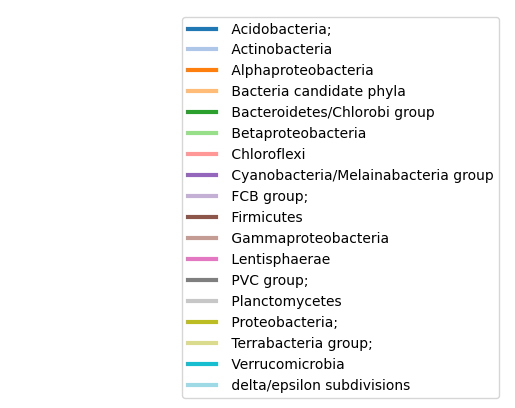

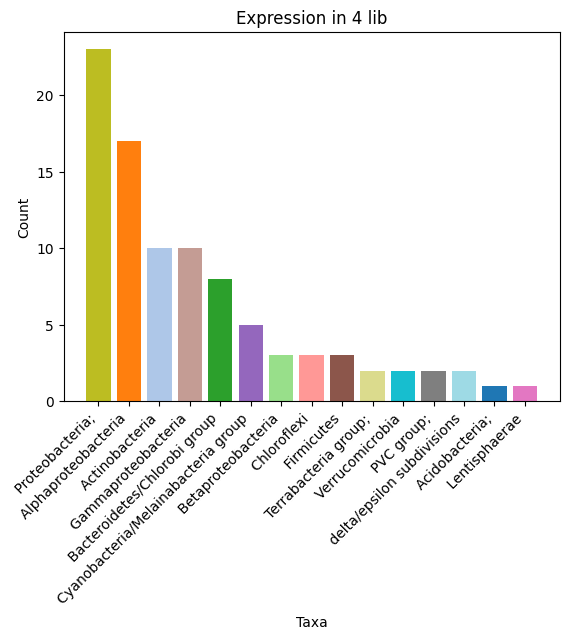

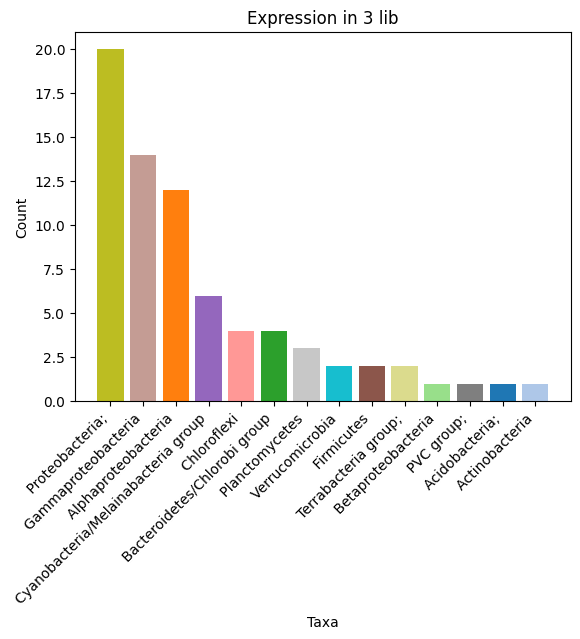

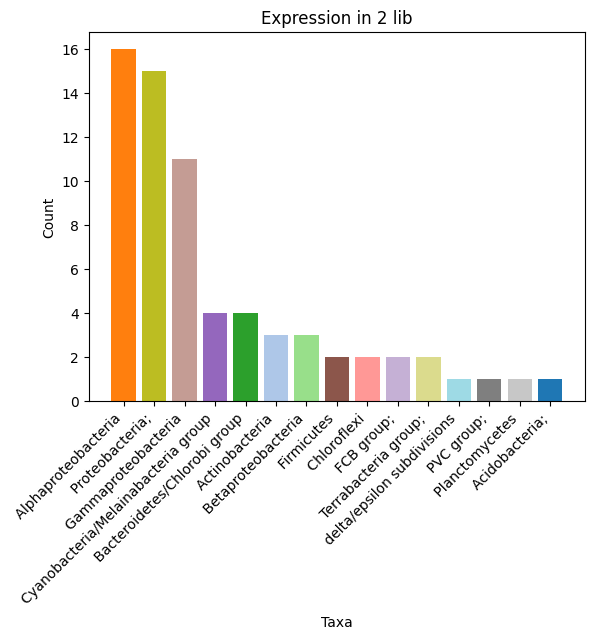

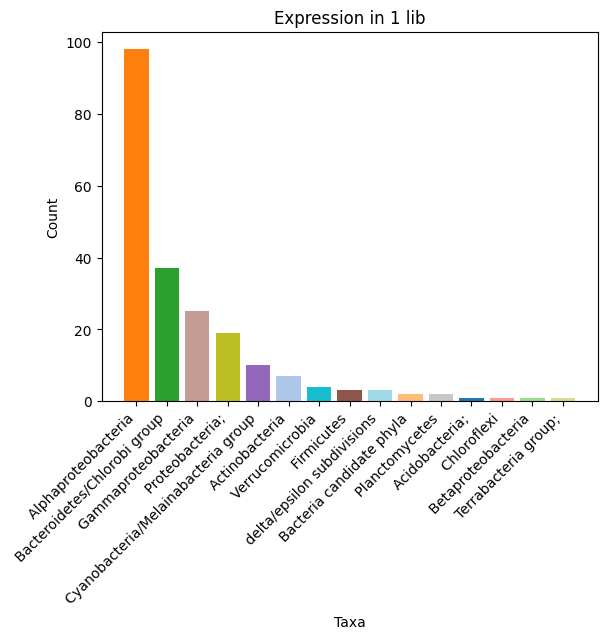

In [7]:
unique_taxa = np.sort(bac_gene['Megan_tax'].unique())
color_map = plt.cm.get_cmap('tab20', len(unique_taxa)) 

for i, taxon in enumerate(unique_taxa):
    plt.plot([], [], color=color_map(i), label=taxon, linewidth=3)
plt.legend(loc='upper right')
plt.axis('off')  
#plt.savefig(f"Bac_express_legend.svg", format="svg")
plt.show()

for idx, sample in enumerate([4, 3, 2, 1]):
    counts = bac_gene[bac_gene.gene_express == sample]['Megan_tax'].value_counts()
    colors = [color_map.colors[unique_taxa.tolist().index(tax)] for tax in counts.index]
    plt.bar(counts.index, counts.values, color=colors)
    plt.xlabel('Taxa')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title(f"Expression in {sample} lib")
    plt.savefig(f"Bac_express_{sample}.svg", format="svg")
    plt.show()


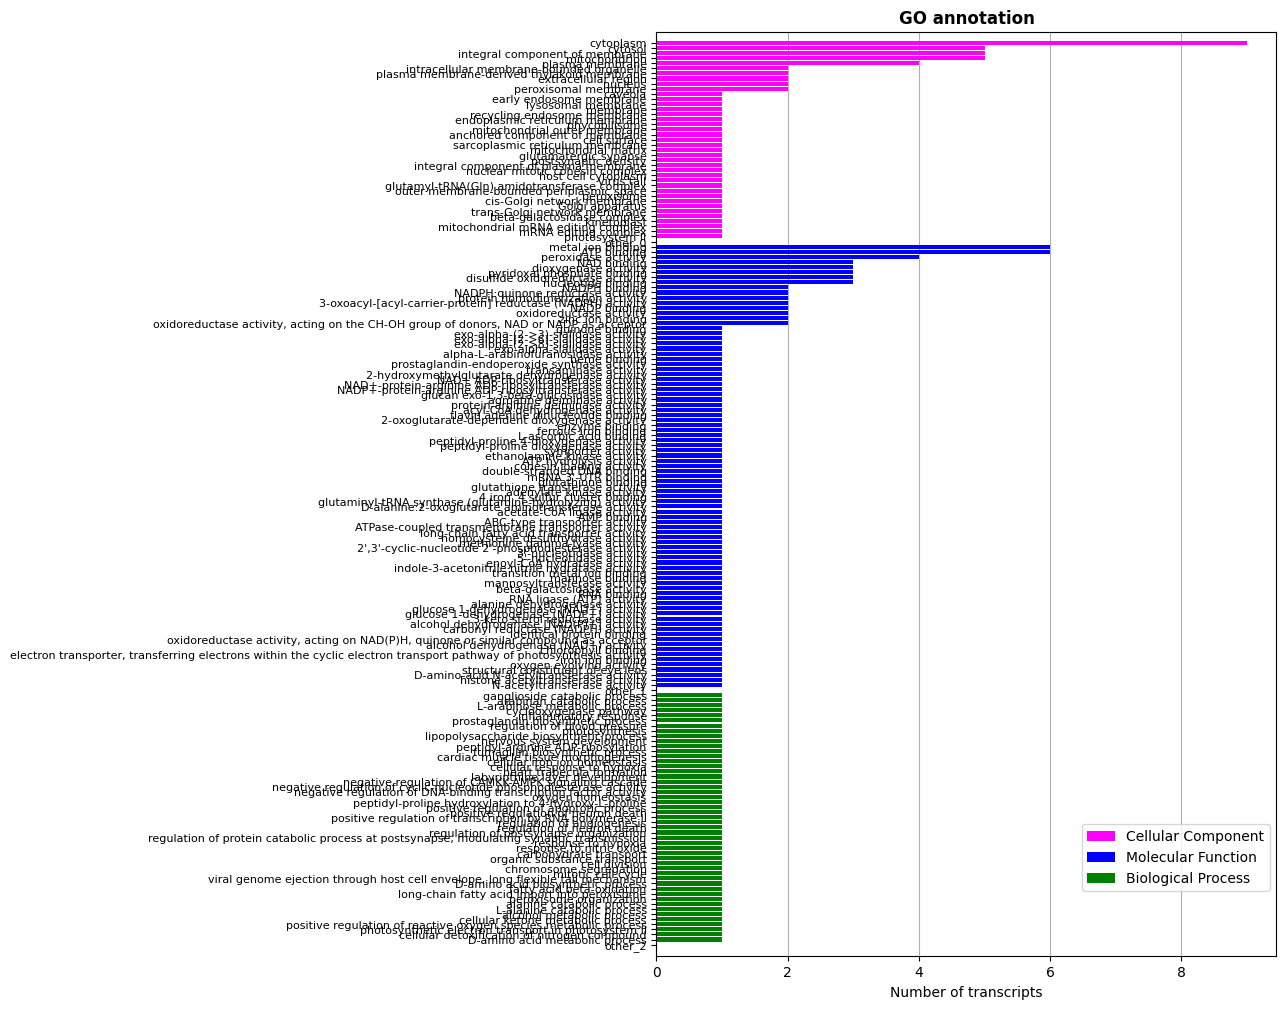

In [8]:
comb_go(bac_gene[bac_gene.gene_express == 4],o=1)

In [9]:
bac_gene[
    ((bac_gene['Megan_tax'] == ' Cyanobacteria/Melainabacteria group') | (bac_gene['AvP_tax'] == 'Cyanobacteriota'))
].sort_values(['gene_express'], ascending=[False]).to_csv('expressed_cyano_gene.csv', index=False)


bacteria COG annotation

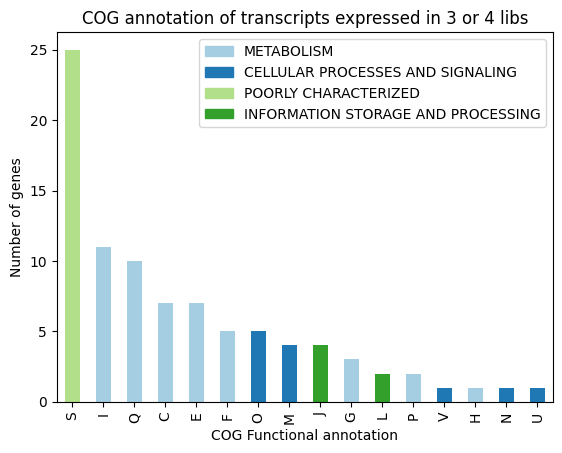

In [10]:
Bac_cog = pd.read_csv(r'd:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\Megan\hgt_candidate.emapper.annotations.tsv', sep='\t', skiprows=4, skipfooter=3, engine='python')
fun=pd.read_csv(r'd:\Uni\Programmes\COG\fun.txt', sep='\t', header=None)

Bac_cog = (pd.merge(bac_gene,Bac_cog,how='left',left_on='prot_id',right_on='#query')).dropna()
Bac_cog['COG_category'] = Bac_cog['COG_category'].apply(list)
Bac_cog = Bac_cog.explode('COG_category')
eggnog_m = pd.merge(Bac_cog, fun, left_on='COG_category', right_on=1)[['#query','COG_category',0,2,'gene_express']]

def plot_bargraph_with_groupings(df, groupby, colourby, title, xlabel, ylabel):
    """
    Plots a dataframe showing the frequency of datapoints grouped by one column and coloured by another.
    df : dataframe
    groupby: the column to groupby
    colourby: the column to color by
    title: the graph title
    xlabel: the x label,
    ylabel: the y label
    """
    # Makes a mapping from the unique colourby column items to a random color.
    ind_col_map = {x:y for x, y in zip(df[colourby].unique(),
                               [plt.cm.Paired(np.arange(len(df[colourby].unique())))][0])}

    # Find when the indicies of the soon to be bar graphs colors.
    unique_comb = df[[groupby, colourby]].drop_duplicates()
    name_ind_map = {x:y for x, y in zip(unique_comb[groupby], unique_comb[colourby])}
    c = df[groupby].value_counts().index.map(lambda x: ind_col_map[name_ind_map[x]])

    # Makes the bargraph.
    ax = df[groupby].value_counts().plot(kind='bar',
                                         title=title,
                                         color=c.values)
    # Makes a legend using the ind_col_map
    legend_list = []
    for key in ind_col_map.keys():
        legend_list.append(mpatches.Patch(color=ind_col_map[key], label=key))

    # display the graph.
    plt.legend(handles=legend_list, loc=0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #plt.savefig(f"Bac_express_COG.svg", format="svg")
    plt.show()

plot_bargraph_with_groupings((eggnog_m[eggnog_m.gene_express >= 3]),'COG_category',0,'COG annotation of transcripts expressed in 3 or 4 libs','COG Functional annotation','Number of genes')
#for i in [4,3,2,1]:
#    plot_bargraph_with_groupings((eggnog_m[eggnog_m.gene_express == i]),'COG_category',0,'COG annotation of transcripts expressed in '+ str(i) + ' libs','COG Functional annotation','Number of genes')

All genes - non Dinoflagellate
---

In [11]:
# Drop Alveolata (host) and Metazoam, Opisthokonta (contamination)
non_dino_gene = all_tax_gene.fillna('NA')[~all_tax_gene.fillna('NA').Megan_tax.str.contains("Alveolata")]
non_dino_gene = non_dino_gene[~non_dino_gene.Megan_tax.str.contains("Metazoa")]
non_dino_gene = non_dino_gene[~non_dino_gene.Megan_tax.str.contains("Opisthokonta")]
#non_dino_gene.to_csv(r'D:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\Megan\gene_all_tax.csv')
non_dino_gene['gene_express'].value_counts()

4    8337
1    7569
3    6715
2    5246
Name: gene_express, dtype: int64

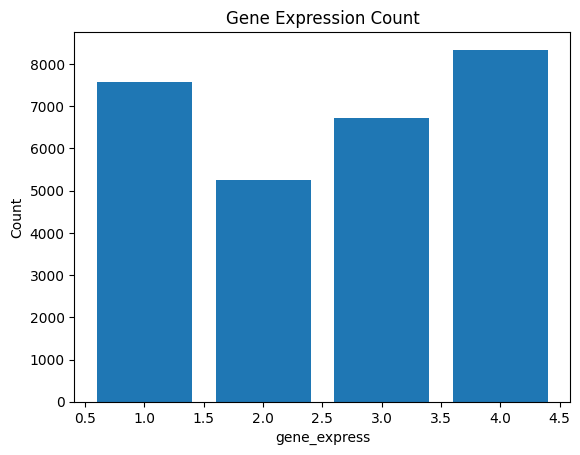

In [12]:
non_dino_gene_count = non_dino_gene['gene_express'].value_counts()
plt.bar(non_dino_gene_count.index, non_dino_gene_count.values)
plt.xlabel('gene_express')
plt.ylabel('Count')
plt.title('Gene Expression Count')
plt.show()

In [13]:
for i in [4,3,2,1]:
    print('In lib', i)
    print(non_dino_gene[non_dino_gene.gene_express == i]['Megan_tax'].value_counts())

In lib 4
NA                                      5823
 Eukaryota;                             1027
 cellular organisms;                     430
 Stramenopiles                           165
 Bacteria;                               165
 Sar;                                    150
 Haptophyta                               91
 Proteobacteria;                          56
 Alphaproteobacteria                      47
 Chlorophyta                              41
 Actinobacteria                           38
 Streptophyta                             38
 Fungi                                    37
 Gammaproteobacteria                      32
NCBI;                                     24
 Bacteroidetes/Chlorobi group             19
 Evosea                                   17
 delta/epsilon subdivisions               14
 Terrabacteria group;                     13
 Betaproteobacteria                       12
 Choanoflagellata                         12
 Pyrenomonadales                          11
 

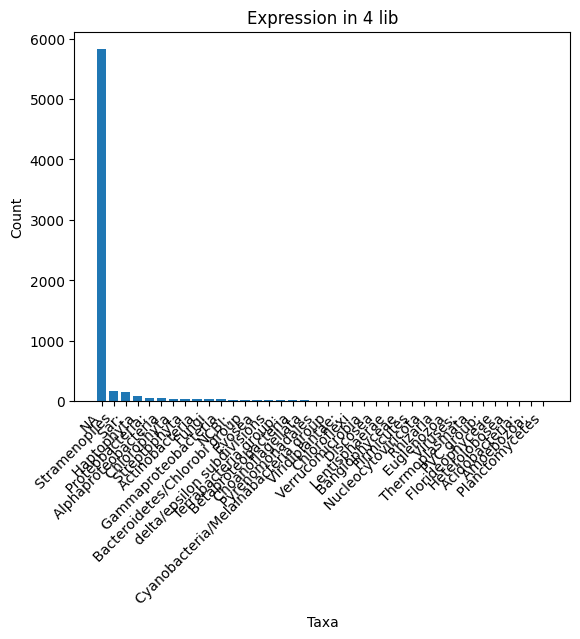

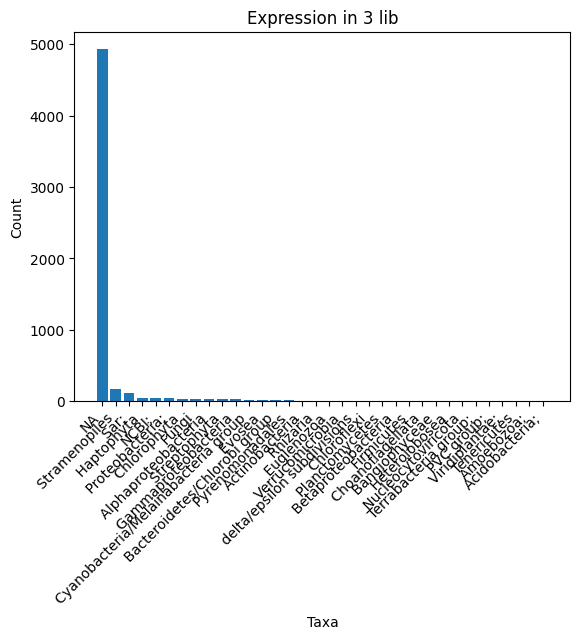

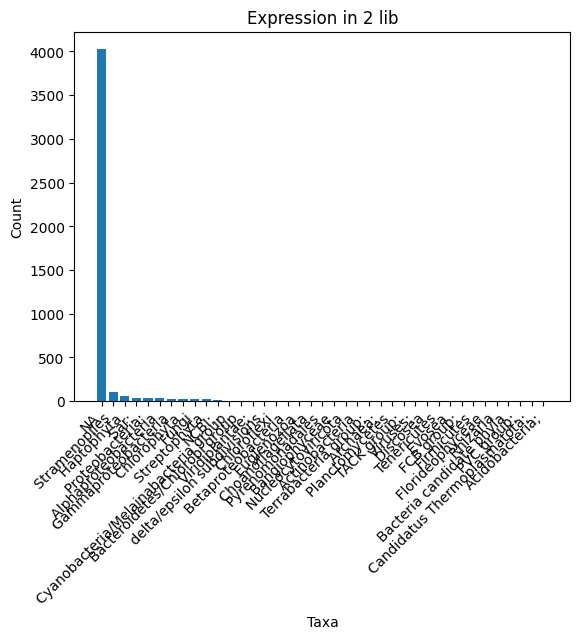

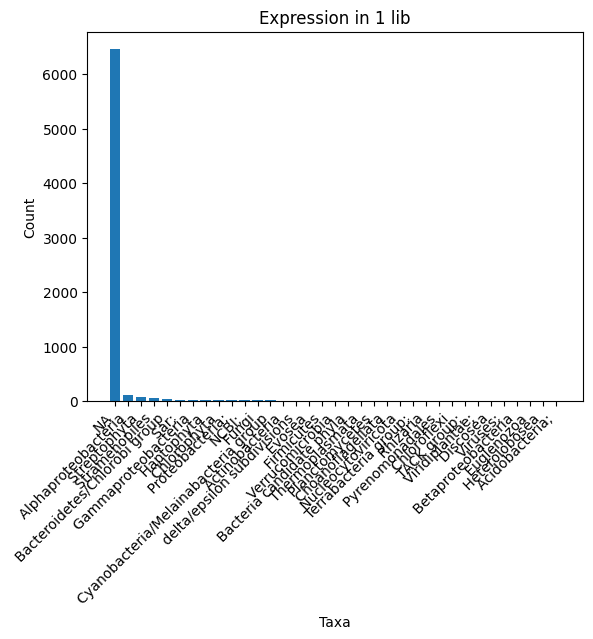

In [14]:
# Drop ambigious taxa classification (euk, prok, cellular organisms)
filtered_non_dino_gene = non_dino_gene[~non_dino_gene.Megan_tax.str.contains("Eukaryota;")]
filtered_non_dino_gene = filtered_non_dino_gene[~filtered_non_dino_gene.Megan_tax.str.contains("cellular organisms;")]
filtered_non_dino_gene = filtered_non_dino_gene[~filtered_non_dino_gene.Megan_tax.str.contains("Bacteria;")]

# Graph
for i in [4,3,2,1]:
    plt.bar(filtered_non_dino_gene[filtered_non_dino_gene.gene_express == i]['Megan_tax'].value_counts().index, filtered_non_dino_gene[filtered_non_dino_gene.gene_express == i]['Megan_tax'].value_counts().values)
    plt.xlabel('Taxa')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title(f"Expression in {i} lib")
    plt.show()

In [15]:
dino = pd.read_csv(r'd:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\Megan\Dinophyceae_pep_taxpath.tsv', header=None, sep='\t')
dino_annotate = (pd.merge(dino,annotate,left_on=0,right_on='prot_id')).drop(columns=['#gene_id', 'RNAMMER', 'transcript', 'peptide'])
#dino_annotate.to_csv(r'd:\Uni\Dino\Projects\Sino\Transcriptome\clean_1234\Megan\Dinophyceae_pep_annotate.csv', index = False)
dino_loc = (pd.merge(dino_annotate,localisation,left_on='prot_id',right_on='Protien ID'))
